### Load and Inspect the Dataset

In [1]:
import pandas as pd
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization,LeakyReLU
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from torch.utils.data import TensorDataset, DataLoader


In [2]:
train_df = pd.read_csv('arxiv_train.csv')
test_df = pd.read_csv('arxiv_test.csv')

# Data exploration

In [3]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

train_df.info()
train_df.head()


Train shape: (80000, 3)
Test shape: (20000, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  80000 non-null  int64 
 1   abstract    80000 non-null  object
 2   label       80000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.8+ MB


,Unnamed: 0,abstract,label
0,31716,Automatic meeting analysis is an essential f...,eess
1,89533,We propose a protocol to encode classical bi...,quant-ph
2,82700,A number of physically intuitive results for...,quant-ph
3,78830,In the last decade rare-earth hexaborides ha...,physics
4,94948,We introduce the weak barycenter of a family...,stat


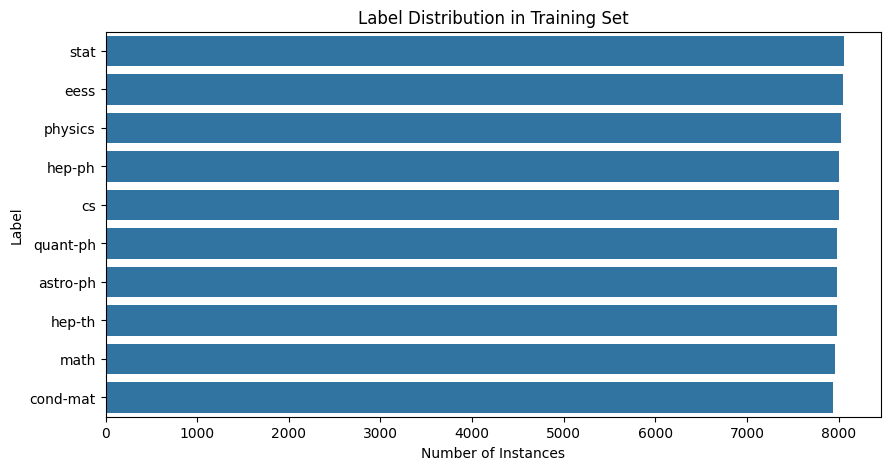

In [4]:
plt.figure(figsize=(10, 5))
sns.countplot(y='label', data=train_df, order=train_df['label'].value_counts().index)
plt.title('Label Distribution in Training Set')
plt.xlabel('Number of Instances')
plt.ylabel('Label')
plt.show()


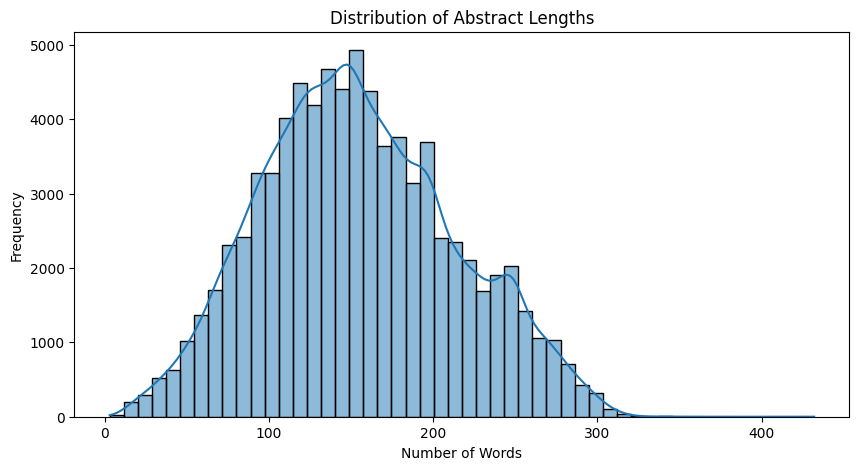

In [5]:
train_df['abstract_length'] = train_df['abstract'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 5))
sns.histplot(train_df['abstract_length'], bins=50, kde=True)
plt.title('Distribution of Abstract Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


### starting preprocessing you lame ass nigga

- checking null values

In [6]:
print("Train missing values:\n", train_df.isnull().sum())
print("Test missing values:\n", test_df.isnull().sum())

Train missing values:
 Unnamed: 0         0
abstract           0
label              0
abstract_length    0
dtype: int64
Test missing values:
 Unnamed: 0    0
abstract      0
label         0
dtype: int64


- removing na

In [7]:
train_df.dropna(subset=['abstract', 'label'], inplace=True)
test_df.dropna(subset=['abstract', 'label'], inplace=True)

- removing extra spaces, new lines, tabs

In [8]:
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    text = text.lower()
    return text

train_df['clean_abstract'] = train_df['abstract'].apply(clean_text)
test_df['clean_abstract'] = test_df['abstract'].apply(clean_text)


 Apply the Tokenization to Your DataFrame

In [9]:
def simple_tokenize(text):
    tokens = re.findall(r'\b\w+\b', text) 
    return tokens

train_df['tokens'] = train_df['clean_abstract'].apply(simple_tokenize)
test_df['tokens'] = test_df['clean_abstract'].apply(simple_tokenize)

print(train_df[['clean_abstract', 'tokens']].head())
print(type(train_df['clean_abstract'].iloc[0]))
print(train_df.columns)


                                      clean_abstract  \
0  automatic meeting analysis is an essential fun...   
1  we propose a protocol to encode classical bits...   
2  a number of physically intuitive results for t...   
3  in the last decade rare-earth hexaborides have...   
4  we introduce the weak barycenter of a family o...   

                                              tokens  
0  [automatic, meeting, analysis, is, an, essenti...  
1  [we, propose, a, protocol, to, encode, classic...  
2  [a, number, of, physically, intuitive, results...  
3  [in, the, last, decade, rare, earth, hexaborid...  
4  [we, introduce, the, weak, barycenter, of, a, ...  
<class 'str'>
Index(['Unnamed: 0', 'abstract', 'label', 'abstract_length', 'clean_abstract',
       'tokens'],
      dtype='object')


- encoding labels as integers because its a multiclass problem

In [10]:
label_encoder = LabelEncoder()
train_df['label_encoded'] = label_encoder.fit_transform(train_df['label'])
test_df['label_encoded'] = label_encoder.transform(test_df['label'])
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label mapping:", label_mapping)


Label mapping: {'astro-ph': 0, 'cond-mat': 1, 'cs': 2, 'eess': 3, 'hep-ph': 4, 'hep-th': 5, 'math': 6, 'physics': 7, 'quant-ph': 8, 'stat': 9}


- Stratified Train/Dev Split

In [11]:
train_texts, dev_texts, train_labels, dev_labels = train_test_split(
    train_df['clean_abstract'],
    train_df['label_encoded'],
    test_size=0.2,
    random_state=42,
    stratify=train_df['label_encoded']
)

print("Train label distribution:\n", train_labels.value_counts(normalize=True))
print("Dev label distribution:\n", dev_labels.value_counts(normalize=True))

Train label distribution:
 label_encoded
9    0.100687
3    0.100656
7    0.100281
4    0.100125
2    0.100062
0    0.099844
8    0.099828
5    0.099766
6    0.099469
1    0.099281
Name: proportion, dtype: float64
Dev label distribution:
 label_encoded
9    0.100687
3    0.100625
7    0.100312
4    0.100125
2    0.100062
8    0.099875
0    0.099812
5    0.099750
6    0.099500
1    0.099250
Name: proportion, dtype: float64


In [12]:
y_train = train_labels.values
y_dev = dev_labels.values
label_map = {'astro-ph': 0, 'cond-mat': 1, 'cs': 2, 'eess': 3, 'hep-ph': 4,
             'hep-th': 5, 'math': 6, 'physics': 7, 'quant-ph': 8, 'stat': 9}

# step 1 : text vectorization

- basic count vectorizer

In [13]:
count_vectorizer = CountVectorizer(max_features=10000, stop_words='english')

X_train_count = count_vectorizer.fit_transform(train_texts)
X_dev_count = count_vectorizer.transform(dev_texts)

print("CountVectorizer shape (train):", X_train_count.shape)
print("CountVectorizer shape (dev):", X_dev_count.shape)


CountVectorizer shape (train): (64000, 10000)
CountVectorizer shape (dev): (16000, 10000)


- TF-IDF Vectorization

In [14]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')

X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
X_dev_tfidf = tfidf_vectorizer.transform(dev_texts)

print("TF-IDF shape (train):", X_train_tfidf.shape)
print("TF-IDF shape (dev):", X_dev_tfidf.shape)


TF-IDF shape (train): (64000, 10000)
TF-IDF shape (dev): (16000, 10000)


# building MLP

- converting data to tensors

# run this for BOW tensors

In [15]:

X_train_tensor = torch.tensor(X_train_count.toarray(), dtype=torch.float32)
X_dev_tensor = torch.tensor(X_dev_count.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_dev_tensor = torch.tensor(y_dev, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
dev_dataset = TensorDataset(X_dev_tensor, y_dev_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=64)

- definfing the model

In [16]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes):
        super(FeedforwardNN, self).__init__()
        layers = []
        current_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(current_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3)) 
            current_dim = h
        layers.append(nn.Linear(current_dim, num_classes))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FeedforwardNN(input_dim=10000, hidden_dims=[128], num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss:.4f}")

Epoch 1/5 - Loss: 1167.0837
Epoch 2/5 - Loss: 586.1338
Epoch 3/5 - Loss: 481.0530
Epoch 4/5 - Loss: 422.6243
Epoch 5/5 - Loss: 374.5775


### val results

Accuracy on dev set: 84.19%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1597
           1       0.83      0.81      0.82      1588
           2       0.75      0.69      0.72      1601
           3       0.79      0.82      0.81      1610
           4       0.94      0.93      0.94      1602
           5       0.91      0.93      0.92      1596
           6       0.84      0.87      0.86      1592
           7       0.72      0.71      0.71      1605
           8       0.88      0.87      0.88      1598
           9       0.80      0.85      0.83      1611

    accuracy                           0.84     16000
   macro avg       0.84      0.84      0.84     16000
weighted avg       0.84      0.84      0.84     16000



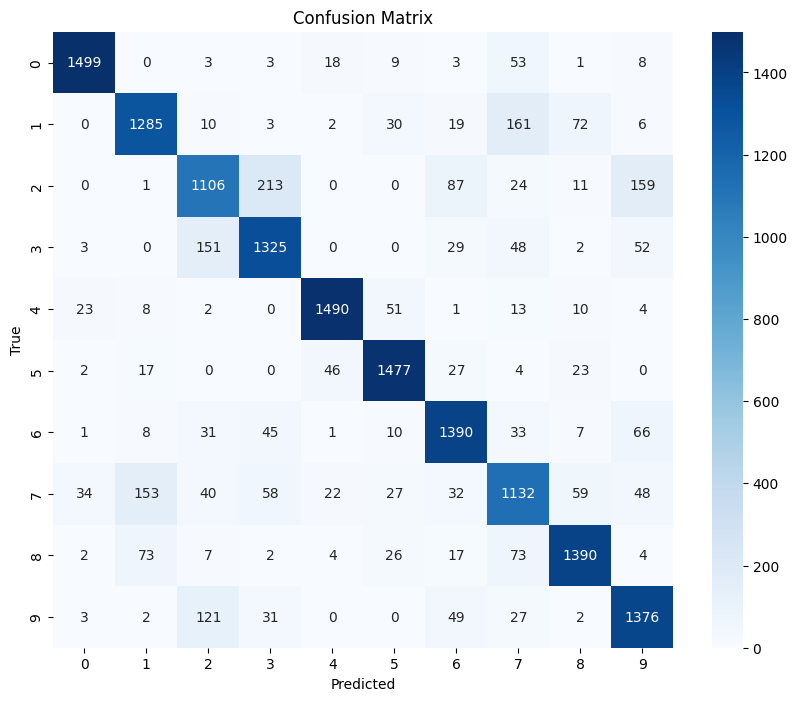

In [18]:
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y in dev_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())
        
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on dev set: {accuracy:.2f}%')


print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### test

CountVectorizer shape (test): (20000, 10000)
Accuracy on test set: 83.97%

Test Set Classification Report:
              precision    recall  f1-score   support

    astro-ph       0.95      0.93      0.94      2013
    cond-mat       0.83      0.81      0.82      2058
          cs       0.76      0.70      0.73      1995
        eess       0.77      0.81      0.79      1948
      hep-ph       0.94      0.92      0.93      1990
      hep-th       0.89      0.91      0.90      2019
        math       0.86      0.88      0.87      2042
     physics       0.72      0.69      0.71      1977
    quant-ph       0.87      0.88      0.87      2013
        stat       0.81      0.85      0.83      1945

    accuracy                           0.84     20000
   macro avg       0.84      0.84      0.84     20000
weighted avg       0.84      0.84      0.84     20000



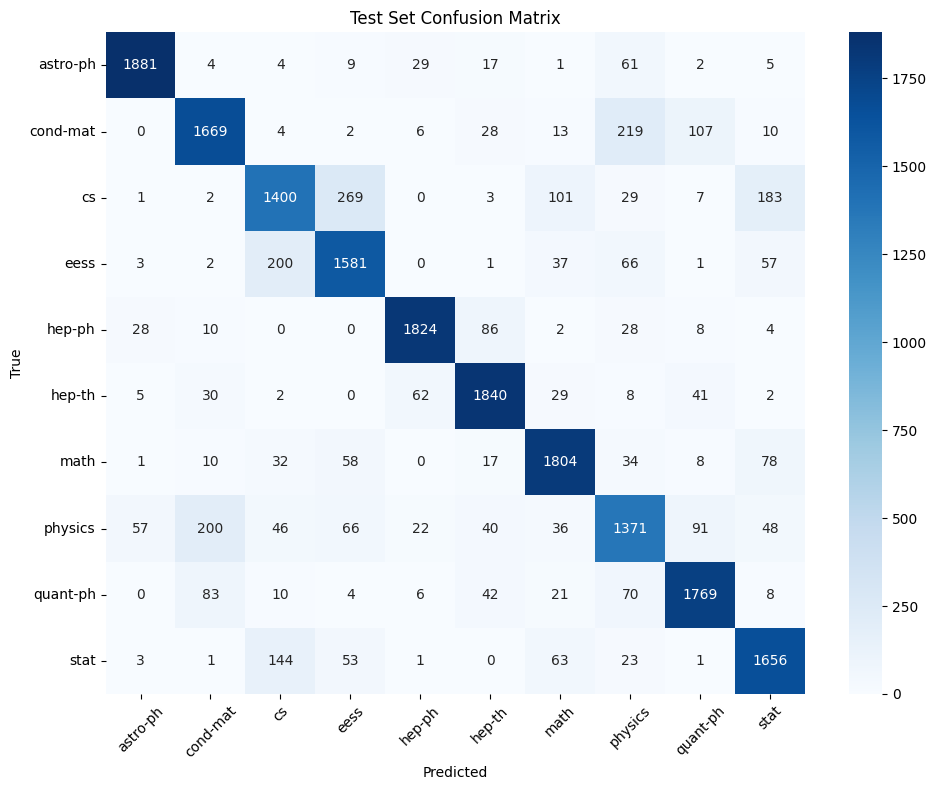

In [19]:
X_test_count = count_vectorizer.transform(test_df['clean_abstract'])
y_test = test_df['label_encoded'].values

print("CountVectorizer shape (test):", X_test_count.shape)

X_test_tensor = torch.tensor(X_test_count.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64)

model.eval()
test_correct = 0
test_total = 0
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        _, predicted = torch.max(outputs.data, 1)
        
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(batch_y.cpu().numpy())
        
        test_total += batch_y.size(0)
        test_correct += (predicted == batch_y).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Accuracy on test set: {test_accuracy:.2f}%')
print("\nTest Set Classification Report:")
print(classification_report(all_test_labels, all_test_preds, 
                           target_names=label_encoder.classes_))

plt.figure(figsize=(10, 8))
cm_test = confusion_matrix(all_test_labels, all_test_preds)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Set Confusion Matrix')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# TF-IDF tensors

In [20]:
X_train_tensor_tf = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
X_dev_tensor_tf = torch.tensor(X_dev_tfidf.toarray(), dtype=torch.float32)

train_dataset_tf = TensorDataset(X_train_tensor_tf, y_train_tensor)
dev_dataset_tf = TensorDataset(X_dev_tensor_tf, y_dev_tensor)

train_loader_tf = DataLoader(train_dataset_tf, batch_size=64, shuffle=True)
dev_loader_tf = DataLoader(dev_dataset_tf, batch_size=64)

New model

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FeedforwardNN(input_dim=10000, hidden_dims=[256], num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader_tf:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss:.4f}")

Epoch 1/10 - Loss: 1757.2033
Epoch 2/10 - Loss: 843.4117
Epoch 3/10 - Loss: 604.3934
Epoch 4/10 - Loss: 512.5834
Epoch 5/10 - Loss: 460.1657
Epoch 6/10 - Loss: 424.7919
Epoch 7/10 - Loss: 396.4054
Epoch 8/10 - Loss: 372.2433
Epoch 9/10 - Loss: 353.2390
Epoch 10/10 - Loss: 333.8626


# validation

Accuracy on dev set: 84.53%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1597
           1       0.83      0.81      0.82      1588
           2       0.76      0.70      0.73      1601
           3       0.79      0.84      0.81      1610
           4       0.94      0.93      0.94      1602
           5       0.91      0.92      0.92      1596
           6       0.87      0.87      0.87      1592
           7       0.72      0.71      0.72      1605
           8       0.88      0.88      0.88      1598
           9       0.80      0.86      0.83      1611

    accuracy                           0.85     16000
   macro avg       0.85      0.85      0.85     16000
weighted avg       0.85      0.85      0.84     16000



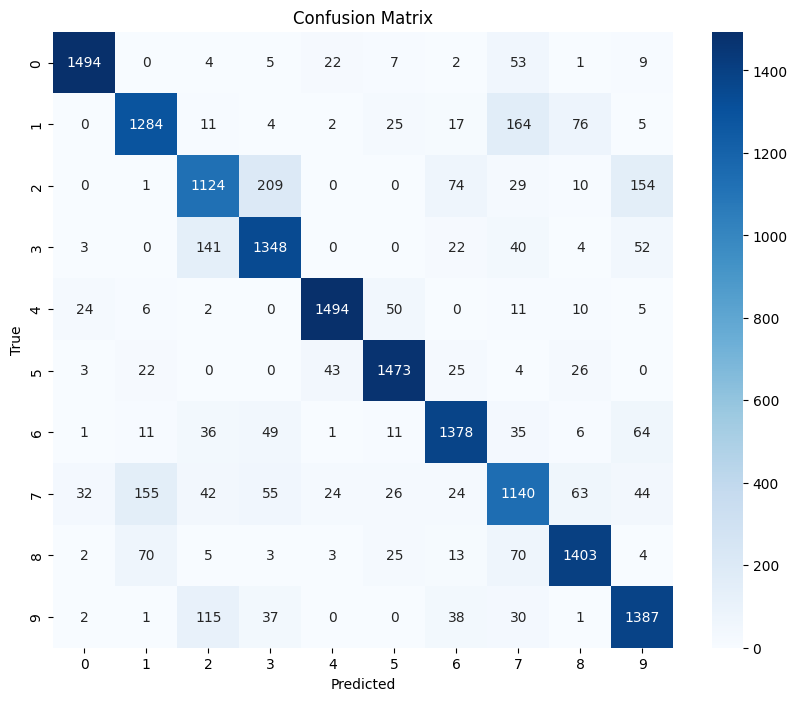

In [22]:
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y in dev_loader_tf:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())
        
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on dev set: {accuracy:.2f}%')
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# test

Accuracy on test set: 82.81%

Test Set Classification Report:
              precision    recall  f1-score   support

    astro-ph       0.93      0.94      0.94      2013
    cond-mat       0.79      0.84      0.82      2058
          cs       0.82      0.60      0.70      1995
        eess       0.70      0.89      0.79      1948
      hep-ph       0.92      0.92      0.92      1990
      hep-th       0.87      0.91      0.89      2019
        math       0.93      0.80      0.86      2042
     physics       0.77      0.57      0.66      1977
    quant-ph       0.83      0.90      0.86      2013
        stat       0.75      0.90      0.82      1945

    accuracy                           0.83     20000
   macro avg       0.83      0.83      0.82     20000
weighted avg       0.83      0.83      0.82     20000



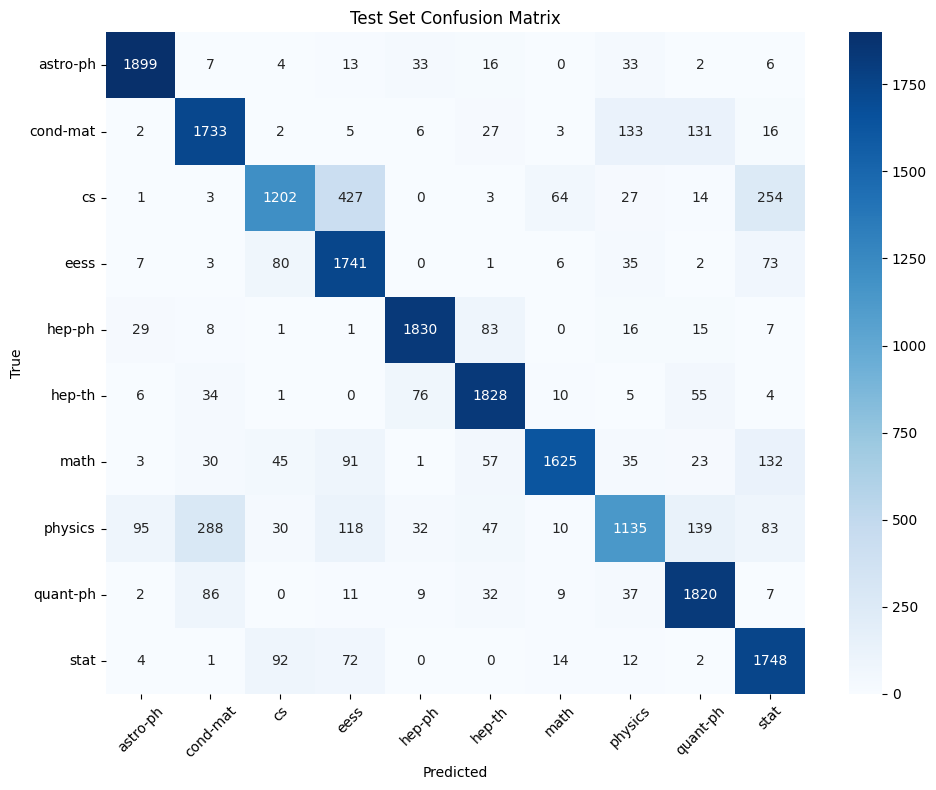

In [23]:
X_test_count = count_vectorizer.transform(test_df['clean_abstract'])
y_test = test_df['label_encoded'].values

X_test_tensor = torch.tensor(X_test_count.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64)

model.eval()
test_correct = 0
test_total = 0
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        _, predicted = torch.max(outputs.data, 1)
        
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(batch_y.cpu().numpy())
        
        test_total += batch_y.size(0)
        test_correct += (predicted == batch_y).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Accuracy on test set: {test_accuracy:.2f}%')

print("\nTest Set Classification Report:")
print(classification_report(all_test_labels, all_test_preds, 
                           target_names=label_encoder.classes_))

plt.figure(figsize=(10, 8))
cm_test = confusion_matrix(all_test_labels, all_test_preds)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Set Confusion Matrix')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step two with pretrained embeddings

### Loading Pretrained Word Embeddings

In [24]:
embedding_index = {}
embedding_dim = 300  

with open('glove.6B.300d.txt', 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefficients = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefficients
        
print("Loaded {} word vectors.".format(len(embedding_index)))

Loaded 400000 word vectors.


 ### Converting Abstracts into Document Vectors

In [25]:
def get_document_vector(tokens, embedding_index, embedding_dim=300, pooling='mean'):
    valid_vectors = [embedding_index[word] for word in tokens if word in embedding_index]
    if not valid_vectors:
        return np.zeros(embedding_dim)
    valid_vectors = np.array(valid_vectors)
    
    if pooling == 'mean':
        return np.mean(valid_vectors, axis=0)
    elif pooling == 'sum':
        return np.sum(valid_vectors, axis=0)
    elif pooling == 'max':
        return np.max(valid_vectors, axis=0)
    else:
        raise ValueError("Unsupported pooling type. Choose 'mean', 'sum', or 'max'.")

### Creating Document Vectors for Training and Test Sets

In [26]:
# for sum pooling
X_train_sum = np.vstack(train_df['tokens'].apply(lambda tokens: get_document_vector(tokens, embedding_index, embedding_dim, pooling='sum')))
y_train_sum = train_df['label'].values
X_test_sum = np.vstack(test_df['tokens'].apply(lambda tokens: get_document_vector(tokens, embedding_index, embedding_dim, pooling='sum')))
y_test_sum = test_df['label'].values

# for mean pooling
X_train_mean = np.vstack(train_df['tokens'].apply(lambda tokens: get_document_vector(tokens, embedding_index, embedding_dim, pooling='mean')))
y_train_mean = train_df['label'].values
X_test_mean = np.vstack(test_df['tokens'].apply(lambda tokens: get_document_vector(tokens, embedding_index, embedding_dim, pooling='mean')))
y_test_mean = test_df['label'].values

# for max pooling
X_train_max = np.vstack(train_df['tokens'].apply(lambda tokens: get_document_vector(tokens, embedding_index, embedding_dim, pooling='max')))
y_train_max = train_df['label'].values
X_test_max = np.vstack(test_df['tokens'].apply(lambda tokens: get_document_vector(tokens, embedding_index, embedding_dim, pooling='max')))
y_test_max = test_df['label'].values

###  Converting String Labels to Integers

In [27]:
le = LabelEncoder()

y_train_encoded_sum = le.fit_transform(y_train_sum)
y_test_encoded_sum = le.transform(y_test_sum)

y_train_encoded_max = le.fit_transform(y_train_max)
y_test_encoded_max = le.transform(y_test_max)

y_train_encoded_mean = le.fit_transform(y_train_mean)
y_test_encoded_mean = le.transform(y_test_mean)


### 4. Building and Training the MLP Classifier

In [28]:

to_categorical = tf.keras.utils.to_categorical

num_classes = 10

y_train_cat_sum = to_categorical(y_train_encoded_sum, num_classes=num_classes)
y_test_cat_sum = to_categorical(y_test_encoded_sum, num_classes=num_classes)

y_train_cat_mean = to_categorical(y_train_encoded_mean, num_classes=num_classes)
y_test_cat_mean = to_categorical(y_test_encoded_mean, num_classes=num_classes)

y_train_cat_max = to_categorical(y_train_encoded_max, num_classes=num_classes)
y_test_cat_max = to_categorical(y_test_encoded_max, num_classes=num_classes)


# model for mean pooling

In [29]:
Sequential = tf.keras.models.Sequential
Dense = tf.keras.layers.Dense
Dropout = tf.keras.layers.Dropout
BatchNormalization = tf.keras.layers.BatchNormalization
model_mean = Sequential()

model_mean.add(Dense(265, activation='relu', input_shape=(embedding_dim,)))
model_mean.add(Dropout(0.3))
model_mean.add(Dense(128, activation='relu'))
model_mean.add(Dropout(0.3))
model_mean.add(Dense(64, activation='relu'))
model_mean.add(Dense(num_classes, activation='softmax'))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

model_mean.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_mean.summary()

C:\Users\Alipc\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 265)            │        79,765 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 265)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        34,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,719 (479.37 KB)

 Trainable params: 122,719 (479.37 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
history_mean = model_mean.fit(X_train_mean, y_train_cat_mean, epochs=15, batch_size=16, validation_data=(X_test_mean, y_test_cat_mean))

Epoch 1/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - accuracy: 0.5044 - loss: 1.3801 - val_accuracy: 0.7357 - val_loss: 0.7584
Epoch 2/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.7173 - loss: 0.8106 - val_accuracy: 0.7542 - val_loss: 0.6975
Epoch 3/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.7389 - loss: 0.7515 - val_accuracy: 0.7621 - val_loss: 0.6793
Epoch 4/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - accuracy: 0.7483 - loss: 0.7201 - val_accuracy: 0.7689 - val_loss: 0.6551
Epoch 5/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - accuracy: 0.7563 - loss: 0.6994 - val_accuracy: 0.7719 - val_loss: 0.6430
Epoch 6/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - accuracy: 0.7586 - loss: 0.6830 - val_accuracy: 0.7776 - val_loss: 0.6328
Epoch 7/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.7681 - loss: 0.6631 - val_accuracy: 0.7759 - val_loss: 0.6292
Epoch 8/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.7708 - loss: 0

In [31]:
loss, accuracy = model_mean.evaluate(X_test_mean, y_test_cat_mean)
print("Test Accuracy:", accuracy)

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7871 - loss: 0.5907
Test Accuracy: 0.7905499935150146


In [32]:
y_pred_probs_mean = model_mean.predict(X_test_mean)
y_pred_mean = np.argmax(y_pred_probs_mean, axis=1)
print(classification_report(y_test_encoded_mean, y_pred_mean))

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2013
           1       0.76      0.77      0.76      2058
           2       0.71      0.66      0.68      1995
           3       0.70      0.80      0.75      1948
           4       0.90      0.86      0.88      1990
           5       0.79      0.88      0.83      2019
           6       0.87      0.81      0.83      2042
           7       0.67      0.58      0.62      1977
           8       0.85      0.82      0.83      2013
           9       0.75      0.81      0.78      1945

    accuracy                           0.79     20000
   macro avg       0.79      0.79      0.79     20000
weighted avg       0.79      0.79      0.79     20000



In [33]:
def plot_training_history(history):
 
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


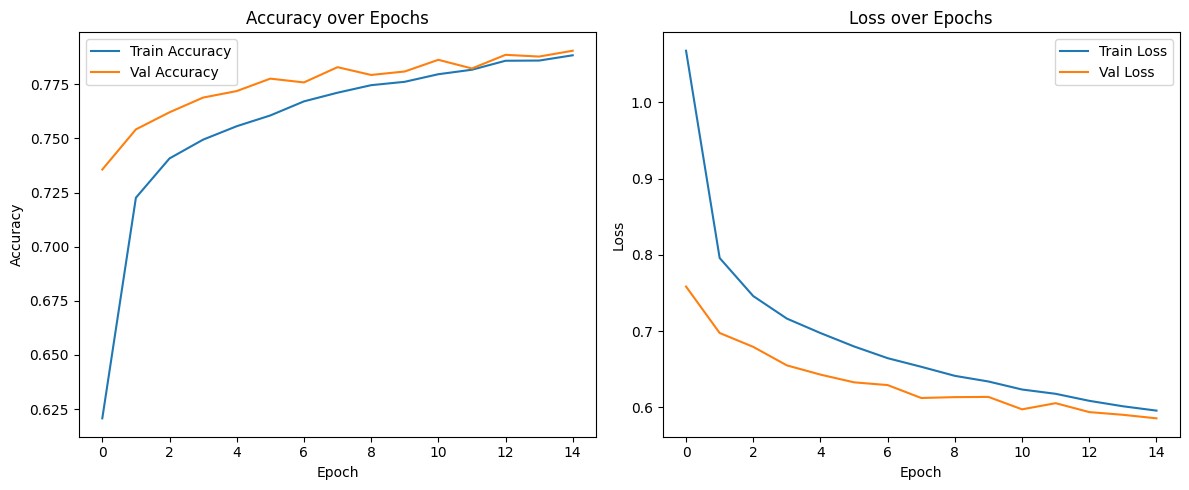

In [34]:
plot_training_history(history_mean)

# model for max pooling 

In [35]:
Sequential = tf.keras.models.Sequential
Dense = tf.keras.layers.Dense
Dropout = tf.keras.layers.Dropout
BatchNormalization = tf.keras.layers.BatchNormalization
model_max = Sequential()

model_max.add(Dense(1024))
model_max.add(LeakyReLU(alpha=0.1))
model_max.add(BatchNormalization())
model_max.add(Dense(512, activation='relu', input_shape=(embedding_dim,)))
model_max.add(Dropout(0.5))
model_max.add(Dense(265, activation='relu', input_shape=(embedding_dim,)))
model_max.add(Dropout(0.4))
model_max.add(Dense(128, activation='relu'))
model_max.add(Dropout(0.3))
model_max.add(Dense(64, activation='relu'))
model_max.add(Dense(num_classes, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_max.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_max.summary()

C:\Users\Alipc\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
C:\Users\Alipc\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [36]:
history_max = model_max.fit(X_train_max, y_train_cat_max, epochs=15, batch_size=16, validation_data=(X_test_max, y_test_cat_max))

Epoch 1/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 127s 23ms/step - accuracy: 0.3980 - loss: 1.6726 - val_accuracy: 0.6673 - val_loss: 0.9688
Epoch 2/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 123s 25ms/step - accuracy: 0.6372 - loss: 1.0655 - val_accuracy: 0.6905 - val_loss: 0.8770
Epoch 3/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 122s 24ms/step - accuracy: 0.6518 - loss: 1.0232 - val_accuracy: 0.6884 - val_loss: 0.8954
Epoch 4/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 106s 21ms/step - accuracy: 0.6704 - loss: 0.9649 - val_accuracy: 0.6716 - val_loss: 0.9471
Epoch 5/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 106s 21ms/step - accuracy: 0.6768 - loss: 0.9414 - val_accuracy: 0.6789 - val_loss: 0.9196
Epoch 6/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 104s 21ms/step - accuracy: 0.6846 - loss: 0.9251 - val_accuracy: 0.6869 - val_loss: 0.8646
Epoch 7/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 102s 20ms/step - accuracy: 0.6920 - loss: 0.8939 - val_accuracy: 0.6974 - val_loss: 0.8660
Epoch 8/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 108s 22ms/step - accuracy: 

In [37]:
loss_max, accuracy_max = model_max.evaluate(X_test_max, y_test_cat_max)
print("Test Accuracy:", accuracy_max)

625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7174 - loss: 0.8139
Test Accuracy: 0.7168999910354614


In [38]:
y_pred_probs_max = model_max.predict(X_test_max)
y_pred_max = np.argmax(y_pred_probs_max, axis=1)
print(classification_report(y_test_encoded_max, y_pred_max))


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      2013
           1       0.58      0.84      0.68      2058
           2       0.62      0.61      0.61      1995
           3       0.63      0.73      0.67      1948
           4       0.89      0.81      0.85      1990
           5       0.90      0.58      0.71      2019
           6       0.72      0.80      0.76      2042
           7       0.67      0.37      0.48      1977
           8       0.82      0.72      0.76      2013
           9       0.66      0.80      0.72      1945

    accuracy                           0.72     20000
   macro avg       0.73      0.72      0.71     20000
weighted avg       0.73      0.72      0.71     20000



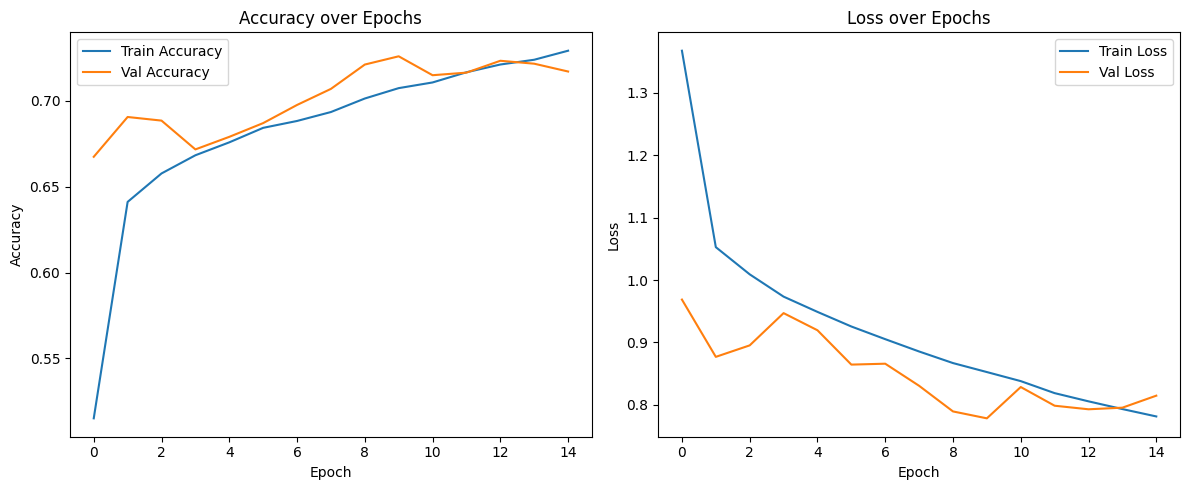

In [39]:
plot_training_history(history_max)

# model for sum pooling

In [40]:
model_sum = Sequential()
model_sum.add(BatchNormalization(input_shape=(embedding_dim,)))
model_sum.add(Dense(192, activation='relu')) 
model_sum.add(Dropout(0.15))
model_sum.add(Dense(96, activation='relu'))
model_sum.add(Dropout(0.15))
model_sum.add(Dense(48, activation='relu'))
model_sum.add(Dense(num_classes, activation='softmax'))

optimizer = Adam(learning_rate=0.0002)

model_sum.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

model_sum.summary()

C:\Users\Alipc\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 192)            │        57,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 96)             │        18,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 48)             │         4,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,666 (322.91 KB)

 Trainable params: 82,066 (320.57 KB)

 Non-trainable params: 600 (2.34 KB)

In [41]:
history_sum = model_sum.fit(
    X_train_sum, y_train_cat_sum,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_sum, y_test_cat_sum),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath='best_sum_pool_model.keras',
            monitor='val_accuracy',
            save_best_only=True
        )
    ]
)


Epoch 1/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - accuracy: 0.5381 - loss: 1.3239 - val_accuracy: 0.7525 - val_loss: 0.7120
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.7203 - loss: 0.8105 - val_accuracy: 0.7671 - val_loss: 0.6688
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.7388 - loss: 0.7525 - val_accuracy: 0.7734 - val_loss: 0.6412
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.7463 - loss: 0.7215 - val_accuracy: 0.7819 - val_loss: 0.6227
Epoch 5/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.7574 - loss: 0.6911 - val_accuracy: 0.7839 - val_loss: 0.6107
Epoch 6/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.7610 - loss: 0.6816 - val_accuracy: 0.7840 - val_loss: 0.6112
Epoch 7/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.7642 - loss: 0.6659 - val_accuracy: 0.7886 - val_loss: 0.5990
Epoch 8/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.7684 - loss: 0

In [42]:
loss, accuracy = model_sum.evaluate(X_test_sum, y_test_cat_sum)
print("Test Accuracy:", accuracy)

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7986 - loss: 0.5769
Test Accuracy: 0.800849974155426


In [43]:
y_pred_probs_sum = model_sum.predict(X_test_sum)
y_pred_sum = np.argmax(y_pred_probs_sum, axis=1)
print(classification_report(y_test_encoded_sum, y_pred_sum))


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      2013
           1       0.78      0.77      0.78      2058
           2       0.75      0.64      0.69      1995
           3       0.70      0.83      0.76      1948
           4       0.90      0.88      0.89      1990
           5       0.82      0.86      0.84      2019
           6       0.84      0.82      0.83      2042
           7       0.70      0.61      0.65      1977
           8       0.83      0.84      0.84      2013
           9       0.76      0.82      0.79      1945

    accuracy                           0.80     20000
   macro avg       0.80      0.80      0.80     20000
weighted avg       0.80      0.80      0.80     20000



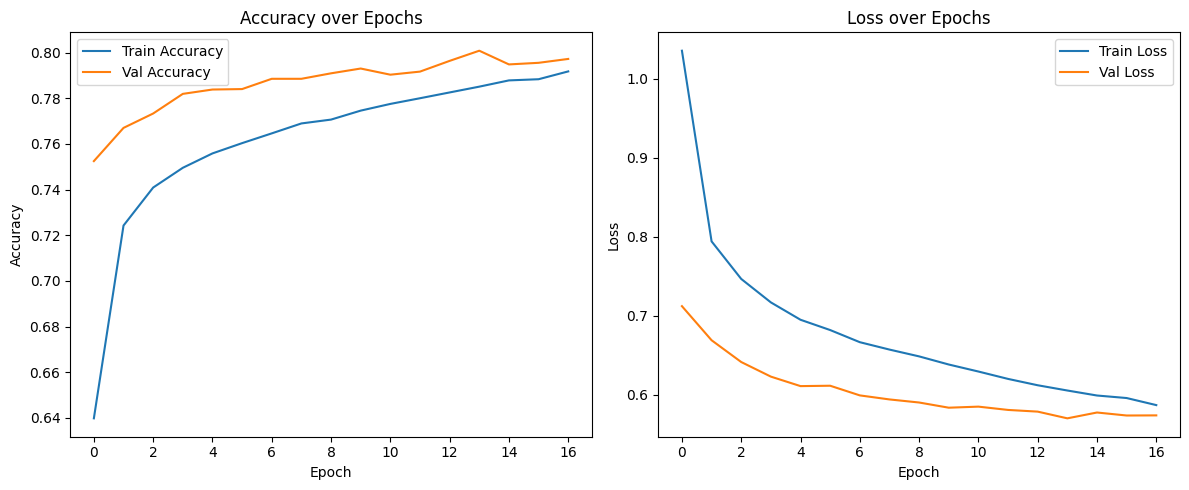

In [44]:
plot_training_history(history_sum)
